# 課題：ダイレクトインデックスの構築方法について
## 背景
* ダイレクトインデックス（Direct indexing）:インデックス投資の一種で、指数に連動する金融商品を保有するのではなくインデックスに連動するように金融商品を直接保有する手法
* 投資家は保有する銘柄を指定でき、特定のテーマの資産を保有する/しないといったニーズを満たすことができる
* インデックス投資 … S&P500等の指数に連動する金融商品を購入<br> 
    〇手数料、少額投資、市場リターン　×カスタマイズ、減税
* ラップ口座 … 個別資産を直接保有するが運用は証券会社が行う<br> 
    〇カスタマイズ、減税　×手数料、少額投資

<br> 
<br> 

## 目的：ダイレクトインデックスのポートフォリオの構築方法について検討する
* 指数に連動するポートフォリオを構築するためには、指数を構成する銘柄を指数の計算方法に基づいた配分で購入すればいいが、構成銘柄数が多すぎる指数については効率面から現実的ではない。
* すべての銘柄ではなく顧客が指定した銘柄でトラッキングエラーを最小化する必要がある。

<br> 
<br> 

## 検証１：銘柄数を指定した場合のポートフォリオ構築方法
* 対象指数：S&P500
* 対象銘柄：指数を構成する500銘柄の内時価総額上位50銘柄
* 計算方法：トラッキングエラーを最小化する様にポートフォリオの配分比率を計算

①50銘柄の3年間（2013年1月～2015年12月）の日次株価データから累積リターンデータ$r=(r_1,r_2,...,r_N)$を算出<br>
②同じ期間のベンチマーク（S&P500）の日次株価データから累積リターンデータ$b=(b_1,b_2,...,b_T)^T$を算出<br>
③各資産の配分比率$w=(w_1,w_2,...,w_N)$から算出される日次のトラッキングエラー$e=(b-rw^T)^2$を最小化する最適化問題をpythonの最適化ソルバーcvxpyで解く<br>
※制約条件は$w>=0,\sum{w}=1$<br>
④計算期間の次の1か月間のポートフォリオの時価データ$p=rw^T$を算出<br>
⑤計算期間を1か月ずらし（2013年2月～2016年1月）①から再計算し、2022年12月まで繰り返す

<br>
<br>

## 結果１
![チャート](di.png)
![円グラフ](pie.png)
![上位銘柄](topw.png)

## 最適化ソルバーについて
今回使用したのは[cvxpy](https://www.cvxpy.org/index.html) <br>
* python上で実行できる最適化問題の数値解（≠解析解）を解くためのツール
* cvxでは様々な最適化問題を扱えるが今回の対象は二次計画法（quadratic programming:QP）<br>
    $\min{\frac{1}{2}x^TPx-q^Tx}$ <br>
    $\rm{subject\ to}\ Ax \le b$
* cvxpyでは種々のアルゴリズムを使用できるがQPを解く際のデフォルトは[OSQP](https://osqp.org/docs/) <br>
　※[リンク](https://www.cvxpy.org/tutorial/advanced/index.html#advanced)

## 今後の展開
* パラメタの検討（最適化対象期間、リバランス頻度、銘柄数等）
* 投資テーマを指定してポートフォリオ構築

In [1]:
import numpy as np
import scipy.stats as st
import cvxpy as cvx
import pandas as pd
import datetime
import warnings
warnings.filterwarnings('ignore')

In [2]:
tickers=pd.read_csv('tickers.csv')
tickers=tickers['ticker'].to_list()
data = pd.read_csv('./data/'+tickers[0]+'.csv')
data = data.drop(['Open', 'High','Low','Close','Adj Close','Volume'], axis=1)
for ticker in tickers:
    d = pd.read_csv('./data/'+ticker+'.csv')
    d = d.drop(['Open', 'High','Low','Adj Close','Volume'], axis=1)
    d = d.rename(columns={'Close': ticker})
    data = pd.merge(data,d,on='Date')

In [3]:
cal = data[['Date']]
cal['Datetime'] = pd.to_datetime(cal['Date'])
cal['year'] = cal['Datetime'].dt.year
cal['month'] = cal['Datetime'].dt.month
cal['week'] = cal['Datetime'].dt.week

In [4]:
cal['mon'] = 1
for index, row in cal.iterrows():
    if index > 0 and cal.iloc[index,3] != cal.iloc[index-1,3]:
        cal.iloc[index,5] = cal.iloc[index-1,5]+1
    else:
        cal.iloc[index,5] = cal.iloc[index-1,5]

In [5]:
data = data.set_index('Date')

In [6]:
R = data.pct_change()
R = R.fillna(0)
R = R + 1
R = R.cumprod()

In [7]:
Benchmark = pd.read_csv('sp500.csv')
Benchmark = Benchmark.set_index('Date')
Benchmark = Benchmark.drop(['Open', 'High','Low','Adj Close','Volume'], axis=1)
Benchmark = Benchmark.pct_change()
Benchmark = Benchmark.fillna(0)
Benchmark = Benchmark + 1
Benchmark = Benchmark.cumprod()

In [8]:
T = R.shape[0]
N = R.shape[1]


In [38]:
di = Benchmark.copy() # ポートフォリオの時価総額の推移
dw = pd.DataFrame(index=R.index,columns=R.columns) # 目標配分比率の推移
di_sr = pd.DataFrame(index=R.index,columns=['Close']) # 同一比率リバランスポートフォリオの時価総額の推移
pw = pd.DataFrame(index=R.index,columns=R.columns) # 実績配分比率の推移

In [32]:
i=2
mon_window = 36
start = i+1
end = i+mon_window
startdate = cal.query('mon >= '+str(start)+' and mon <= '+str(end))['Date'].min()
enddate = cal.query('mon >= '+str(start)+' and mon <= '+str(end))['Date'].max()
asset = R[startdate:enddate]
asset = asset.pct_change()
asset = asset.fillna(0)
asset = asset + 1
asset = asset.cumprod()
asset = asset.values
indx = Benchmark[startdate:enddate]
indx = indx.pct_change()
indx = indx.fillna(0)
indx = indx + 1
indx = indx.cumprod()
indx = indx.values
indx = np.squeeze(indx)

weight = cvx.Variable(N)
obj = cvx.Minimize(cvx.sum_squares(asset@weight - indx))
mintracerr = cvx.Problem(obj, [cvx.sum(weight) == 1.0,weight >= 0])
mintracerr.solve(verbose=False)
w = weight.value
w[w<0]=0
w=w/w.sum()
asset_last = asset[-1,:]
w = w*asset_last
w=w/w.sum()
wt = np.expand_dims(w, 0)
dstart = cal.query('mon >= '+str(end+1)+' and mon <= '+str(end+1))['Date'].min()
dend = cal.query('mon >= '+str(end+1)+' and mon <= '+str(end+1))['Date'].max()
dstartm1 = cal.query('mon >= '+str(end)+' and mon <= '+str(end))['Date'].max()
rtmp=R[dstartm1:dend]
rtmp = rtmp.pct_change()
rtmp = rtmp.dropna()
rtmp = rtmp + 1
dim1 = di[dstartm1:dstartm1].values
w = dim1*w
w = np.squeeze(w)
d = rtmp.values@w
d = np.expand_dims(d, 1)
di[dstart:dend]=d

In [39]:
mon_window = 60
weight = cvx.Variable(N)
for i in range(120 - mon_window):
    start = i+1
    end = i+mon_window
    startdate = cal.query('mon >= '+str(start)+' and mon <= '+str(end))['Date'].min()
    enddate = cal.query('mon >= '+str(start)+' and mon <= '+str(end))['Date'].max()
    asset = R[startdate:enddate]
    asset = asset.pct_change()
    asset = asset.fillna(0)
    asset = asset + 1
    asset = asset.cumprod()
    asset = asset.values
    indx = Benchmark[startdate:enddate]
    indx = indx.pct_change()
    indx = indx.fillna(0)
    indx = indx + 1
    indx = indx.cumprod()
    indx = indx.values
    indx = np.squeeze(indx)
    obj = cvx.Minimize(cvx.sum_squares(asset@weight - indx))
    mintracerr = cvx.Problem(obj, [cvx.sum(weight) == 1.0,weight >= 0])
    mintracerr.solve(verbose=False)
    w = weight.value
    w[w<0]=0
    w=w/w.sum()
    asset_last = asset[-1,:]
    w = w*asset_last
    w=w/w.sum()
    wt = np.expand_dims(w, 0)
    dstart = cal.query('mon >= '+str(end+1)+' and mon <= '+str(end+1))['Date'].min()
    dend = cal.query('mon >= '+str(end+1)+' and mon <= '+str(end+1))['Date'].max()
    dstartm1 = cal.query('mon >= '+str(end)+' and mon <= '+str(end))['Date'].max()
    rtmp=R[dstartm1:dend]
    rtmp = rtmp.pct_change()
    rtmp = rtmp.dropna()
    rtmp = rtmp + 1
    # ポートフォリオ時価総額計算
    dim1 = di[dstartm1:dstartm1].values
    w = dim1*w
    w = np.squeeze(w)
    d = rtmp.values@w
    d = np.expand_dims(d, 1)
    di[dstart:dend]=d
    # 目標配分
    dw[dstart:dstart]=wt
    # 実績配分
    
    # rt = rtmp.shape[0]
    # wr = np.expand_dims(w, 0)
    # wr = np.repeat(wr, rt, axis=0)
    # dwr = np.multiply(rtmp,wr)
    # dwr_sum = dwr.sum(axis=1)
    # dwr_sum = np.expand_dims(dwr_sum, 1)
    # dwr_sumr = np.repeat(dwr_sum, 50, axis=1)
    # dwr_al = np.divide(dwr,dwr_sumr)
    # pw[dstart:dend] = dwr_al
    # 同一比率リバランス
    w_sr = dw['2016-01-04':'2016-01-04'].values
    w_sr = np.squeeze(w_sr)
    d_sr = R[dstart:dend].values@w_sr
    d_sr = np.expand_dims(d_sr, 1)
    di_sr[dstart:dend]=d_sr

In [48]:
dim1 = di[dstartm1:dstartm1].values
# w = dim1*w

In [23]:
dw = dw.dropna()

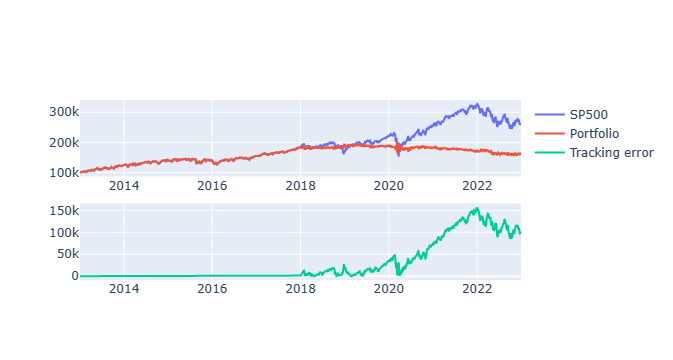

In [40]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
ganpon=100000
fig = make_subplots(rows=2, cols=1)
fig.add_trace(go.Scatter(x=Benchmark.index,
                         y=Benchmark['Close']*ganpon,
                         mode='lines',
                         name='SP500',
                        ), row=1, col=1
              )
fig.add_trace(go.Scatter(x=di.index,
                         y=di['Close']*ganpon,
                         mode='lines',
                         name='Portfolio',
                        ), row=1, col=1
              )
fig.add_trace(go.Scatter(x=Benchmark.index,
                         y=((Benchmark['Close']*ganpon-di['Close']*ganpon)**2)**0.5,
                         mode='lines',
                         name='Tracking error',
                        ), row=2, col=1
              )
fig.show()

In [25]:
Benchmark.to_csv('b.csv')
di.to_csv('d.csv')

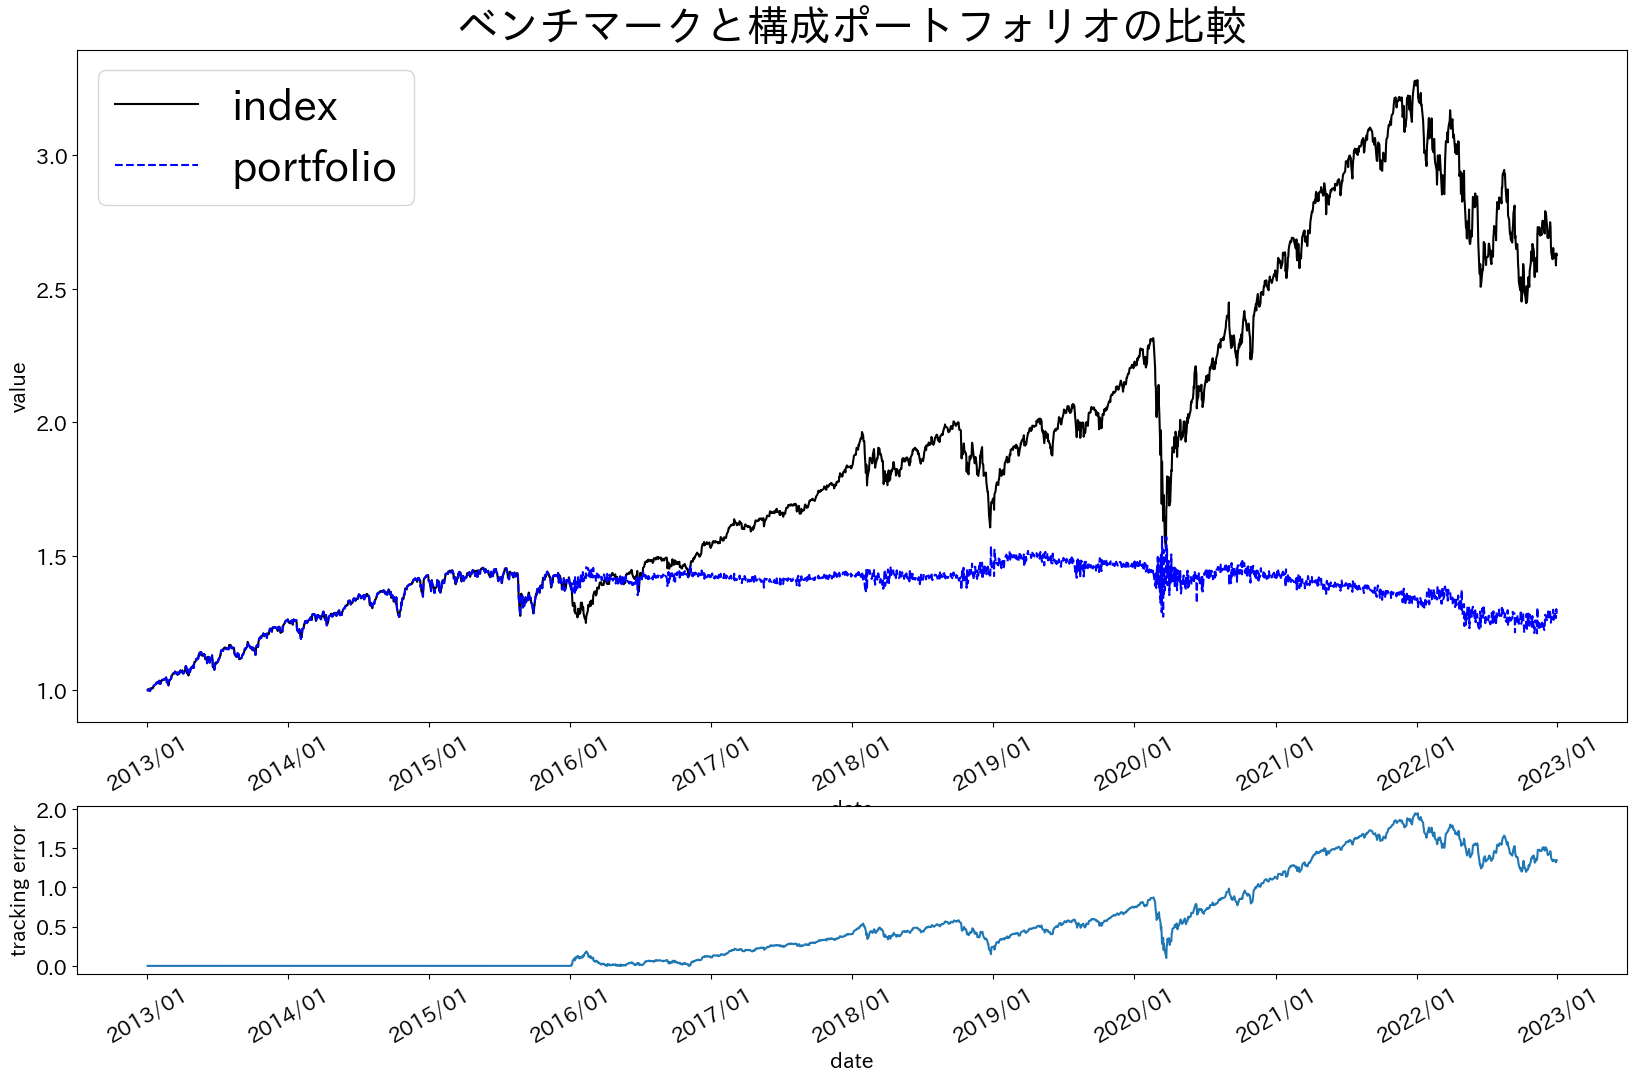

In [25]:
import japanize_matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import dates as mdates

heights = [4, 1]
fig = plt.figure(figsize=(20, 12))
spec = fig.add_gridspec(ncols=1, nrows=2,  height_ratios=heights)
ax = fig.add_subplot(spec[0, 0])
ax.plot(pd.to_datetime(Benchmark.index),Benchmark,c='k')
ax.plot(pd.to_datetime(di.index),di,c='b',linestyle="--")
ax.legend(labels=['index','portfolio'],fontsize=30)
ax.set_xlabel('date', size=15)
ax.set_ylabel('value', size=15)
ax.set_title('ベンチマークと構成ポートフォリオの比較', fontsize=30)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xticks(rotation=30)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y/%m'))

ax = fig.add_subplot(spec[1, 0])
ax.plot(pd.to_datetime(Benchmark.index),((Benchmark['Close']-di['Close'])**2)**0.5)
ax.set_xlabel('date', size=15)
ax.set_ylabel('tracking error', size=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xticks(rotation=30)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y/%m'))

# fig.savefig("di.png")

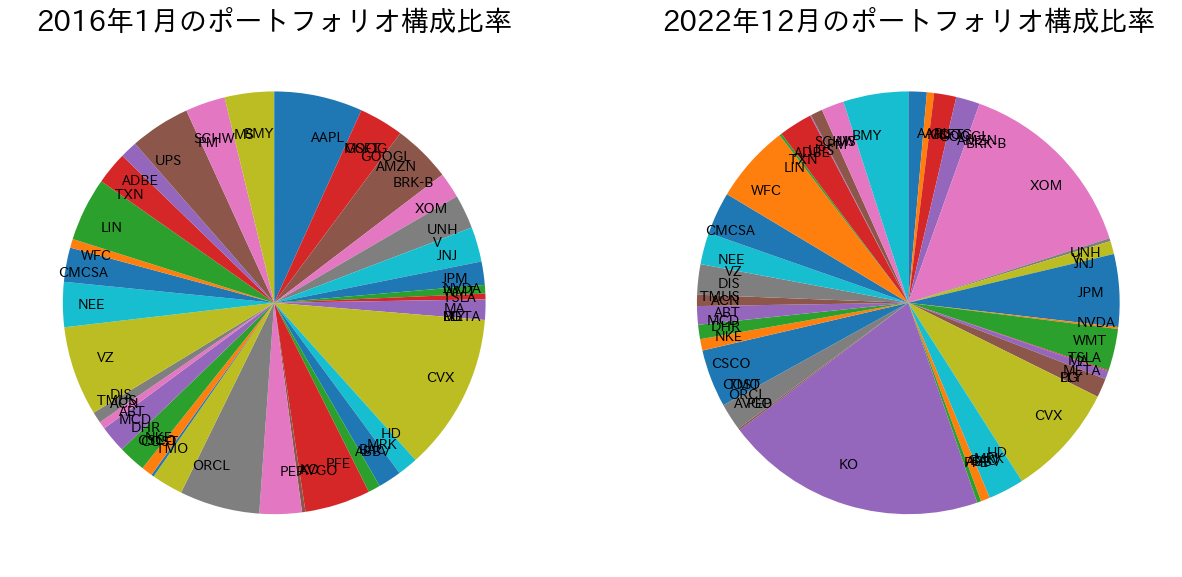

In [27]:
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(121)
ax.pie(dw.iloc[0,:],labels=tickers, counterclock=False, startangle=90, labeldistance=0.8)
ax.set_title('2016年1月のポートフォリオ構成比率', fontsize=20)
ax = fig.add_subplot(122)
ax.pie(dw.iloc[83,:],labels=tickers, counterclock=False, startangle=90, labeldistance=0.8)
ax.set_title('2022年12月のポートフォリオ構成比率', fontsize=20)
fig.savefig("pie.png")

In [28]:
w_sum = dw.sum()
w_sum.sort_values(ascending=False)

XOM      13.53377
KO       6.806443
CVX      4.824086
WFC      3.780232
AAPL     3.056351
PM        2.85019
VZ       2.703573
MS       2.617402
ORCL     2.516712
MRK      2.509575
PFE      2.221913
LIN      2.218192
BMY        2.2166
PEP      2.060705
UPS      2.055085
NEE      2.010287
CSCO     1.930246
HD       1.793683
MA       1.612915
BAC      1.562132
WMT      1.420055
GOOGL    1.380242
JPM      1.340281
TXN      1.260533
NKE      1.240699
DIS      1.230286
DHR      1.201367
TMO       1.03314
SCHW     0.932177
AMZN     0.803412
PG       0.800644
CMCSA    0.785764
COST     0.691508
UNH       0.64452
ADBE     0.604849
TMUS     0.566038
META      0.55465
ABT      0.542732
ABBV     0.351596
JNJ      0.305445
AVGO     0.277561
BRK-B    0.257544
ACN      0.214223
TSLA     0.131417
MSFT      0.13125
GOOG     0.119871
LLY      0.111606
NVDA     0.109465
V        0.076105
MCD       0.00093
dtype: object

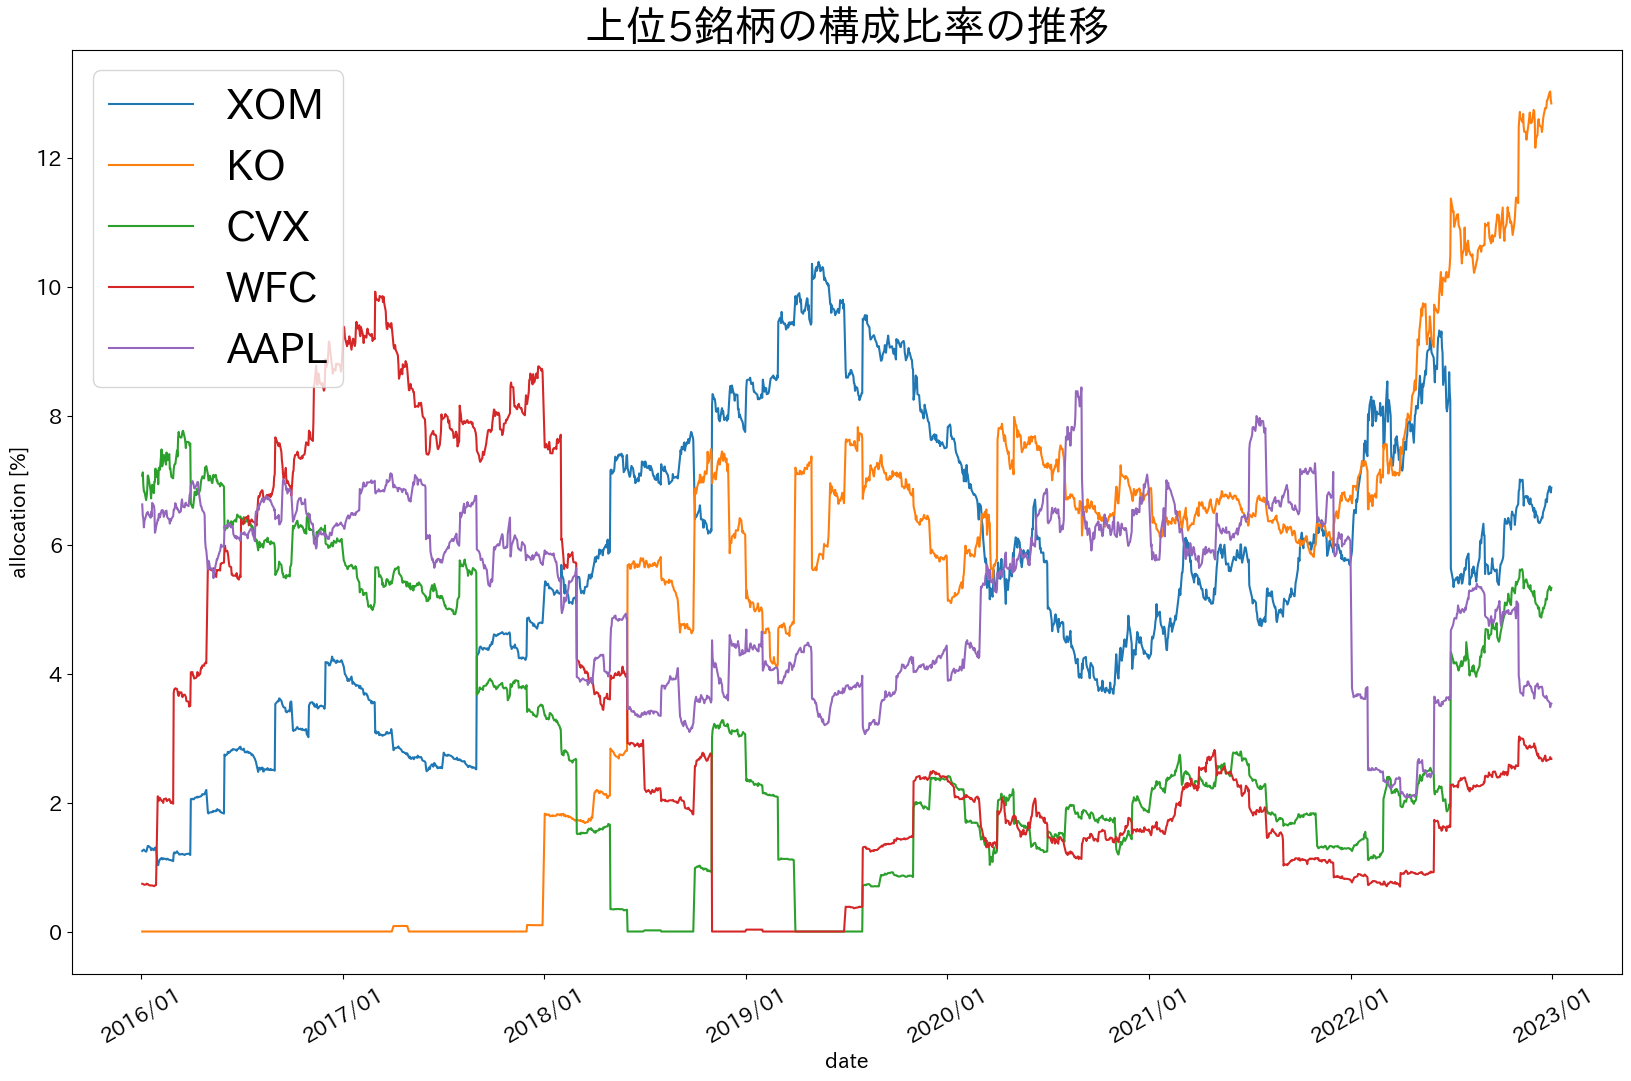

In [29]:
topw = pw[['XOM','KO','CVX','WFC','AAPL']]*100
topw = topw.dropna()

fig = plt.figure(figsize=(20, 12))
ax = fig.add_subplot(111)
ax.plot(pd.to_datetime(topw.index),topw)
ax.legend(labels=topw.columns,fontsize=30)
ax.set_xlabel('date', size=15)
ax.set_ylabel('allocation [%]', size=15)
ax.set_title('上位5銘柄の構成比率の推移', fontsize=30)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xticks(rotation=30)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y/%m'))

fig.savefig("topw.png")

In [31]:
di_nr = pd.DataFrame(index=R.index,columns=['Close']) # 同一比率リバランスポートフォリオの時価総額の推移
d_nr = R['2016-01-04':'2022-12-30'].values@w_sr
d_nr = np.expand_dims(d_nr, 1)
di_nr['2016-01-04':'2022-12-30'] = d_nr

NameError: name 'di_nr' is not defined

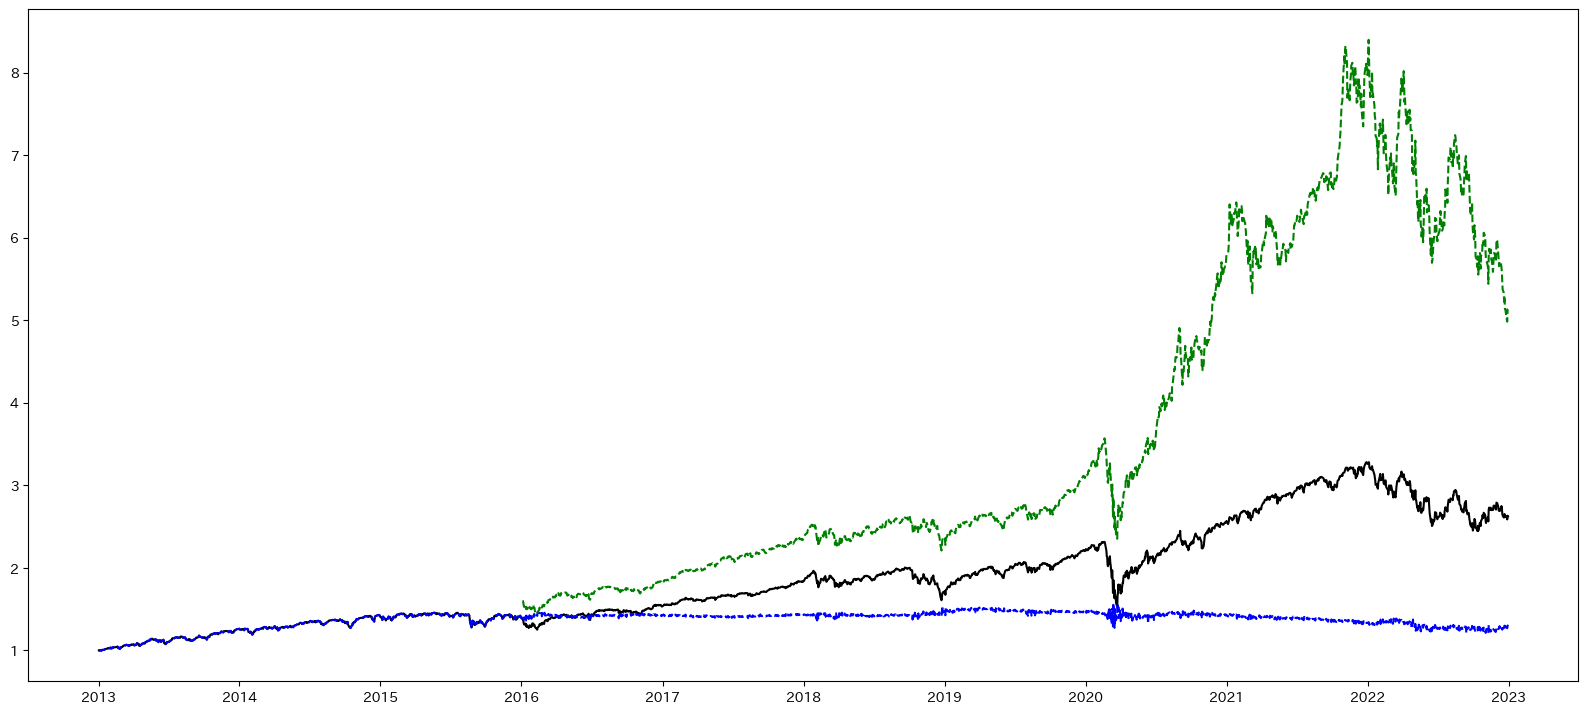

In [26]:
heights = [4, 1]
fig = plt.figure(figsize=(20, 12))
spec = fig.add_gridspec(ncols=1, nrows=2,  height_ratios=heights)
ax = fig.add_subplot(spec[0, 0])
ax.plot(pd.to_datetime(Benchmark.index),Benchmark,c='k')
ax.plot(pd.to_datetime(di.index),di,c='b',linestyle="--")
ax.plot(pd.to_datetime(di_sr.index),di_sr,c='g',linestyle="--")
ax.plot(pd.to_datetime(di_nr.index),di_nr,c='m',linestyle="--")
ax.legend(labels=['index','portfolio','constant allocation'],fontsize=30)
ax.set_xlabel('date', size=15)
ax.set_ylabel('value', size=15)
ax.set_title('リバランスなし、同一比率でのリバランスとの比較', fontsize=30)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xticks(rotation=30)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y/%m'))

ax = fig.add_subplot(spec[1, 0])
ax.plot(pd.to_datetime(Benchmark.index),((Benchmark['Close']-di['Close'])**2)**0.5)
ax.set_xlabel('date', size=15)
ax.set_ylabel('tracking error', size=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xticks(rotation=30)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y/%m'))

# fig.savefig("di.png")

In [52]:
R.to_csv('R.csv')
dw.to_csv('dw.csv')